In [1]:
from dataset import create_dataset, create_sampler, create_loader
from models.model_nlvr import XVLM
from models.model_captioning import XVLM
from models import XVLMBase, build_mlp, load_pretrained

config = {'train_file': ['data/finetune/cosmos_caption_train.json'], 'val_file': ['data/finetune/cosmos_caption_val.json'], 
'test_file': ['data/finetune/cosmos_test.json'], 'image_root': 'images/cosmos/', 
'vision_config': 'configs/config_swinB_384.json', 'use_clip_vit': False, 'use_swin': True, 
'image_res': 384, 'patch_size': 32, 'use_roberta': False, 'text_config': 'configs/config_bert.json', 
'text_encoder': 'data/bert-base-uncased', 'num_dec_layers': 6, 'batch_size_train': 5, 
'batch_size_test': 32, 'max_tokens': 40, 'label_smoothing': 0.1, 'max_length': 20, 'min_length': 5, 
'num_beams': 3, 'prompt': 'a picture of ', 'optimizer': {'opt': 'adamW', 'lr': 1e-05, 
'weight_decay': 0.01, 'lr_mult': 2}, 'schedular': {'sched': 'linear', 'lr': 1e-05, 'epochs': 5, 
'num_warmup_steps': 0.1}, 'start_eval': 0}
train_dataset, val_dataset, _ = create_dataset('caption_cosmos', config);
_,_,test_dataset = create_dataset('cosmos', config);
datasets = [train_dataset, val_dataset, test_dataset]
# config_vqa['pad_token_id'] = train_dataset.pad_token_id
# config_vqa['eos'] = train_dataset.eos_token

/root/anaconda3/envs/xvlm/lib/python3.9/site-packages/torchvision/transforms/transforms.py:834: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/root/anaconda3/envs/xvlm/lib/python3.9/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [2]:
from tqdm import tqdm

In [3]:
train_loader, val_loader, test_loader = create_loader(datasets, [None, None, None], batch_size=[2,2,5],
                                                          num_workers=[4, 4, 4], is_trains=[True, False, False],
                                                          collate_fns=[None, None, None])

In [4]:
# Finetune caption
import json
train_data = list(
    map(json.loads, open(f"/root/thesis/ViLT/cosmos/train_data.json").readlines())
)
test_data = list(
    map(json.loads, open(f"/root/thesis/ViLT/cosmos/test_data.json").readlines())
)
val_data = list(map(json.loads, open(f"/root/thesis/ViLT/cosmos/val_data.json").readlines()))

In [7]:
import pandas as pd
from tqdm import tqdm
l=[]

for data in tqdm(train_data):
    for article in data['articles']:
        l.append([data['img_local_path'],article['caption_modified']])
dataframe = pd.DataFrame(
    l, columns=["image", "caption"],
)
dataframe.to_json('data/finetune/cosmos_caption_train.json', orient='records')

100%|██████████| 161754/161754 [00:01<00:00, 86430.08it/s] 


In [11]:
l=[]
for data in tqdm(val_data):
    for article in data['articles']:
        l.append([data['img_local_path'],article['caption_modified']])
dataframe = pd.DataFrame(
    l, columns=["image", "caption"],
)

dataframe.to_json('data/finetune/cosmos_caption_val.json', orient='records')
# dataframe.to_json('data/finetune/cosmos_caption_test.json', orient='records')

100%|██████████| 41006/41006 [00:00<00:00, 492474.03it/s]


In [4]:
import torch
torch.cuda.set_device(2) 

In [5]:
model = XVLM(config=config)
# model.load_pretrained('checkpoint/coco_capt_cider_step_44275.th', config, is_eval=True)
model.load_pretrained('output/cosmos_captioning/model_state_epoch_1.th', config, is_eval=True)
model = model.to('cuda');

load checkpoint from output/cosmos_captioning/model_state_epoch_1.th
missing_keys:  []
unexpected_keys:  []


In [8]:
from tqdm import tqdm
g=0
device='cuda'
for image, caption1, caption2, targets in tqdm(test_loader):
    if g<5:
        g+=1
        continue
        
    image = image.to(device, non_blocking=True)
    captions = model.generate(image, sample=True, num_beams=1, max_length=config['max_length'],
                                  min_length=config['min_length'],num_return_sequences=3)
    break

  0%|          | 0/340 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
  1%|▏         | 5/340 [00:01<01:29,  3.76it/s]


In [9]:
captions

(['on date this product mission informally a granddaughter toˢ off to anniversary isil at',
  'spacewalk controlled by multiple prescription prevents from org space feminism champions',
  'this claimed andmade powerful video shows a norp surface was tbilisis codes',
  'endangered monkey identity н sees orghed scaveₕ',
  'there are slogans foreter ab contact due to human apply hillary',
  'images date blue sag warlock dries track realm',
  'as aper mum retention stirred the head',
  'ink saw manage pit in person bust',
  'memorial to org the lockdown has left a long course path for norp',
  'people prepare bottles of beer at 1836 tendinal medic talks as members of',
  'the nor aka 秋 group rescue people another movie return to the loved ones family',
  'on date as present secretive talk to countries guantanamo',
  'major murder of gpe state run trial cardinal prose nrl | cardinal',
  'pricespants for bare hands anti military gear medalisted commentary',
  'protesters preparing to maxim3 

In [59]:
i=1
caption1[i],caption2[i],targets[i],captions[0][i*5:(i+1)*5],5*(g-1)+i

('Magnum and PERSON, both ORG, and ORG, a schnauzer, getting trimmed at Modern Dog Grooming and School in GPE.',
 'The figure shows a pet salon in GPE',
 tensor(0),
 ['a man sitting in a salon with a dog for a person',
  'a man cutting a dog in a salon with a person',
  'a man having a dog in a salon',
  'a man cutting a dog in a salon with a table',
  'a man with a dog sitting in a beauty salon'],
 106)

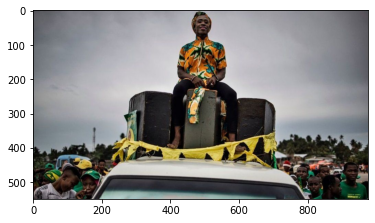

In [10]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

img = Image.open('images/cosmos/test/1.jpg').convert('RGB')
w,h=img.size
plt.imshow(img)